In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import duckdb

In [37]:
import warnings 
warnings.filterwarnings('ignore')

In [7]:
path_train = 'train.parquet'

### Exploratory data analysis

In [121]:
con = duckdb.connect()

# counts grouped

con.query(f"""SELECT COUNT(id), protein_name, binds
                FROM parquet_scan('{path_train}')
                GROUP BY (protein_name, binds)
                ORDER BY (protein_name, binds)""")

┌───────────┬──────────────┬───────┐
│ count(id) │ protein_name │ binds │
│   int64   │   varchar    │ int64 │
├───────────┼──────────────┼───────┤
│  97958646 │ BRD4         │     0 │
│    456964 │ BRD4         │     1 │
│  98007200 │ HSA          │     0 │
│    408410 │ HSA          │     1 │
│  97691078 │ sEH          │     0 │
│    724532 │ sEH          │     1 │
└───────────┴──────────────┴───────┘

In [125]:
con.query(f"""SELECT COUNT(DISTINCT id) FROM parquet_scan('{path_train}')""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│ count(DISTINCT id) │
│       int64        │
├────────────────────┤
│          295246830 │
└────────────────────┘

In [127]:
con.query(f"""SELECT COUNT(DISTINCT molecule_smiles) FROM parquet_scan('{path_train}')""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────────────┐
│ count(DISTINCT molecule_smiles) │
│              int64              │
├─────────────────────────────────┤
│                        98415610 │
└─────────────────────────────────┘

In [ ]:
con.query(f"""SELECT COUNT(DISTINCT molecule_smiles) FROM parquet_scan(''))

### Simple first model

For the first pass, I will make a classifier to predict whether a molecule will bind to BRD4 (1 of 3 target proteins in this dataset). Given BRD4, HSA, and sEH are different proteins, it *might* be better to make 3 models instead of a general one. 

I will use some of the dataset, artificially balancing the data by choosing the same number of rows for bind=0 and bind=1 for BRD4 (30,000 rows each; in the full dataset, 456964 molecules bind to BRD4.

In [9]:
with duckdb.connect() as con:
    df = con.query(f"""(SELECT * 
                        FROM parquet_scan('{path_train}')
                        WHERE protein_name = 'BRD4' AND binds = 1
                        ORDER BY RANDOM()
                        LIMIT 30000) 
                        UNION ALL 
                        (SELECT * 
                        FROM parquet_scan('{path_train}')
                        WHERE protein_name = 'BRD4' AND binds = 0
                        ORDER BY RANDOM()
                        LIMIT 30000)""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
pd.set_option('display.max_columns', None)

In [13]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,255104868,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CNC(=O)c1ccc(N)cc1F,Nc1cc(Br)ccn1,CNC(=O)c1ccc(Nc2nc(Nc3cc(Br)ccn3)nc(N[C@H](CC(...,BRD4,1
1,74421894,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1c(N)cccc1F,Nc1cc(Cl)c(O)c(Cl)c1,Cc1c(F)cccc1Nc1nc(Nc2cc(Cl)c(O)c(Cl)c2)nc(NC(C...,BRD4,1
2,39088515,COc1cccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Nc1ccc2c(c1)CNC2=O,NCc1nc2c(s1)CCCC2,COc1cccc(C(=O)N[Dy])c1Nc1nc(NCc2nc3c(s2)CCCC3)...,BRD4,1
3,200252673,O=C(Nc1ccc(Cl)nc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Nc1cc[nH]c(=O)n1,O=C(N[Dy])c1nc(Cl)ccc1Nc1nc(Nc2cc[nH]c(=O)n2)n...,BRD4,1
4,17697678,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1ccc(N)cc1OC,Cl.Cl.NCc1ccc(-n2cncn2)cc1,COc1ccc(Nc2nc(NCc3ccc(-n4cncn4)cc3)nc(NC(CC(C)...,BRD4,1


In [17]:
df.groupby('binds')['id'].count()

binds
0    30000
1    30000
Name: id, dtype: int64

In [19]:
df['buildingblock1_smiles'].nunique()

271

In [21]:
df['buildingblock2_smiles'].nunique()

693

In [23]:
df['buildingblock3_smiles'].nunique()

865

In [25]:
df['molecule_smiles'].nunique()

60000

In [27]:
from rdkit import Chem

In [81]:
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule
0,255104868,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CNC(=O)c1ccc(N)cc1F,Nc1cc(Br)ccn1,CNC(=O)c1ccc(Nc2nc(Nc3cc(Br)ccn3)nc(N[C@H](CC(...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa0580>
1,74421894,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1c(N)cccc1F,Nc1cc(Cl)c(O)c(Cl)c1,Cc1c(F)cccc1Nc1nc(Nc2cc(Cl)c(O)c(Cl)c2)nc(NC(C...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa02e0>
2,39088515,COc1cccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Nc1ccc2c(c1)CNC2=O,NCc1nc2c(s1)CCCC2,COc1cccc(C(=O)N[Dy])c1Nc1nc(NCc2nc3c(s2)CCCC3)...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa05f0>
3,200252673,O=C(Nc1ccc(Cl)nc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Nc1cc[nH]c(=O)n1,O=C(N[Dy])c1nc(Cl)ccc1Nc1nc(Nc2cc[nH]c(=O)n2)n...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa0660>
4,17697678,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1ccc(N)cc1OC,Cl.Cl.NCc1ccc(-n2cncn2)cc1,COc1ccc(Nc2nc(NCc3ccc(-n4cncn4)cc3)nc(NC(CC(C)...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa06d0>


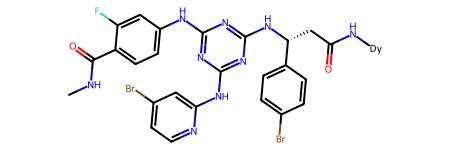

In [83]:
df['molecule'][0]

In [85]:
# Generate ECFPs

from rdkit.Chem import rdFingerprintGenerator

mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

df['ecfp'] = df['molecule'].apply(mfpgen.GetFingerprint).apply(lambda bitvec: list(bitvec))

In [139]:
ecfp_test = df['molecule'].apply(mfpgen.GetFingerprint)
ecfp_test.head()

0    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: molecule, dtype: object

In [141]:
type(ecfp_test[0])

rdkit.DataStructs.cDataStructs.ExplicitBitVect

In [143]:
df['ecfp'].head()

0    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ecfp, dtype: object

In [145]:
ecfp_test[0] == df['ecfp'][0]

False

In [147]:
ecfp_test[0]

In [151]:
type(df['ecfp'][0])

list

In [86]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,255104868,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CNC(=O)c1ccc(N)cc1F,Nc1cc(Br)ccn1,CNC(=O)c1ccc(Nc2nc(Nc3cc(Br)ccn3)nc(N[C@H](CC(...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa0580>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,74421894,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1c(N)cccc1F,Nc1cc(Cl)c(O)c(Cl)c1,Cc1c(F)cccc1Nc1nc(Nc2cc(Cl)c(O)c(Cl)c2)nc(NC(C...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa02e0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,39088515,COc1cccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Nc1ccc2c(c1)CNC2=O,NCc1nc2c(s1)CCCC2,COc1cccc(C(=O)N[Dy])c1Nc1nc(NCc2nc3c(s2)CCCC3)...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa05f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,200252673,O=C(Nc1ccc(Cl)nc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Nc1cc[nH]c(=O)n1,O=C(N[Dy])c1nc(Cl)ccc1Nc1nc(Nc2cc[nH]c(=O)n2)n...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa0660>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,17697678,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1ccc(N)cc1OC,Cl.Cl.NCc1ccc(-n2cncn2)cc1,COc1ccc(Nc2nc(NCc3ccc(-n4cncn4)cc3)nc(NC(CC(C)...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x17aaa06d0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [91]:
X = np.array(df['ecfp'].to_list())
X.shape

(60000, 2048)

In [93]:
X[:5]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [95]:
y = df['binds']

In [97]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
X_train.shape

(48000, 2048)

In [101]:
y_train.shape

(48000,)

In [103]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=4)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

In [105]:
y_hat = clf.predict(X_test)

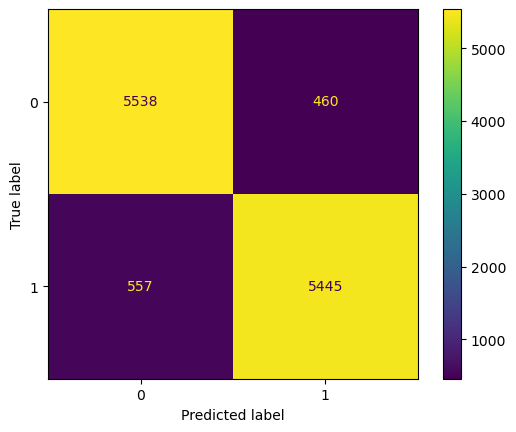

In [107]:
cm = confusion_matrix(y_test, y_hat)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmp.plot()
plt.show()

In [130]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

acc = accuracy_score(y_test, y_hat)
prc = precision_score(y_test, y_hat)
f1s = f1_score(y_test, y_hat)

print('Accuracy: %.2f' % acc)
print('Precision: %.2f' % prc)
print('F1 score: %.2f' % f1s)

Accuracy: 0.92
Precision: 0.92
F1 score: 0.91


Next steps

In [ ]:
# option 1: make multiple dfs (but will this take up all my memory) 
# option 2: make UDFs and do conversions with duckdb 
# get id, molecule_smiles, protein_name, and binds from train.parquet 
# convert molecule_smiles to molecule 
# get ECFP 
# divide dataset into training and test set 
# considerations: ratio between binds=0 and binds=1 in training data?


In [ ]:
# full training for BRD4 binding classifier 
# I do wonder if I'll need to use Spark after all 

In [ ]:
# full training for HSA binding classifier 

In [ ]:
# full training for sEH binding classifier 

In [ ]:
# for the test set (for submission) 

# process data (molecule_smiles > molecule > ECFP)
# predict binding based on protein_name 